# AOI definition tutorial
This tutorial describes methods and utilities for AOI definition. Firstly, we will check all AOI methods and load the dataset.

In [1]:
from eyetracking.preprocessing.aoi_extraction import ThresholdBased, ShapeBased
from eyetracking.visualization.static_visualization import scanpath_visualization
import os, requests
import pandas as pd

def load_data():
    if not os.path.exists("data/em-y35-fasttext.csv"):
        url = "https://zenodo.org/records/4655840/files/em-y35-fasttext.csv?download=1"
        response = requests.get(url, stream=True)
    
        os.makedirs("data", exist_ok=True)
        with open("data/em-y35-fasttext.csv", "wb") as handle:
            for data in response.iter_content(chunk_size=1024):
                handle.write(data)
    
    df = pd.read_csv("data/em-y35-fasttext.csv")
    df.X = df.X/df.X.max()
    df.Y = df.Y/df.Y.max()
    df = df.rename(columns={'FDUR': 'duration', 'X': 'norm_pos_x', 'Y': 'norm_pos_y'})
    X = df[['SUBJ_NAME', 'TEXT', 'norm_pos_x', 'norm_pos_y', 'duration']]
    Y = df[['SUBJ_NAME', 'TEXT', 'TEXT_TYPE', 'TEXT_TYPE_2']].drop_duplicates()
    other_features = df.drop(columns = ['SUBJ_NAME', 'TEXT', 'norm_pos_x', 'norm_pos_y', 'duration'])
    
    return X, Y, other_features

In [2]:
x = "norm_pos_x"
y = "norm_pos_y"
pk = ["SUBJ_NAME", "TEXT"]
data, target, other = load_data()
data.head()

,SUBJ_NAME,TEXT,norm_pos_x,norm_pos_y,duration
0,s01,chasse_oiseaux-a1,0.376268,0.384969,96
1,s01,chasse_oiseaux-a1,0.437754,0.383532,129
2,s01,chasse_oiseaux-a1,0.546146,0.382957,280
3,s01,chasse_oiseaux-a1,0.706643,0.399626,278
4,s01,chasse_oiseaux-a1,0.724645,0.397615,266


Delete the records that contain less than 2 fixation.

In [3]:
data["to_filter"] = data.apply(lambda row: '_'.join([str(row[column]) for column in pk]), axis=1)
data.head()

,SUBJ_NAME,TEXT,norm_pos_x,norm_pos_y,duration,to_filter
0,s01,chasse_oiseaux-a1,0.376268,0.384969,96,s01_chasse_oiseaux-a1
1,s01,chasse_oiseaux-a1,0.437754,0.383532,129,s01_chasse_oiseaux-a1
2,s01,chasse_oiseaux-a1,0.546146,0.382957,280,s01_chasse_oiseaux-a1
3,s01,chasse_oiseaux-a1,0.706643,0.399626,278,s01_chasse_oiseaux-a1
4,s01,chasse_oiseaux-a1,0.724645,0.397615,266,s01_chasse_oiseaux-a1


In [4]:
groups_count = data.groupby("to_filter").size()
mask = groups_count.loc[groups_count > 2].index
data = data.loc[data["to_filter"].isin(mask)]

Columns of data:
* ```SUBJ_NAME``` — id of the participant
* ```TEXT``` — label of the text
* ```norm_pos_x``` — normalized x-axis coordinate of the fixation [0, 1]
* ```norm_pos-y``` — normalized y-axis coordinate of the fixation [0, 1]
* ```duration``` — duration of the fixation in ms

## Shape-based method
It is a very simple method. It gets data with fixations, a list of tuples with shapes (rectangle, circle, ellipse), where each shape is a particular AOI, and a primary key. The last one is distinctive for each record. This method just checks if each fixation is in shape.

In [5]:
shape_based = ShapeBased(x, y, shapes=[[['r', (0., 0.7), (1., 1.)], ('r', (0., 0.5), (1., 0.7)), ('r', (0., 0.), (1., 0.5)),],], pk=pk, aoi_name="AOI") 
result_sb = shape_based.transform(data)

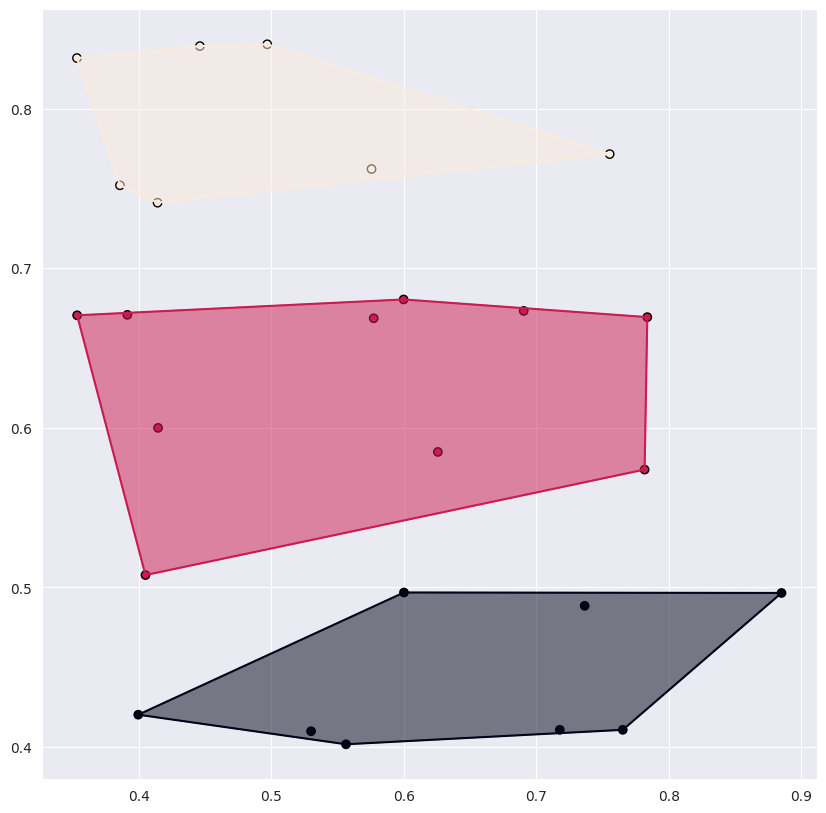

In [6]:
scanpath_visualization(result_sb[(result_sb['SUBJ_NAME'] == "s04") & (result_sb['TEXT'] == "chasse_oiseaux-a1")], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True, only_points=True)

## Threshold-based
This method defines AOI by using kernel density estimation and pre-thresholding it. Each maximum in the windows is the center of the AOI. This method also needs the parameter ```window_size``` (the parameter of the sliding window where the method finds the density maximum).

In [7]:
threshold_based = ThresholdBased(x=x, y=y, threshold=0.5, pk=pk, window_size=10, aoi_name="AOI")
result_tb = threshold_based.transform(data)

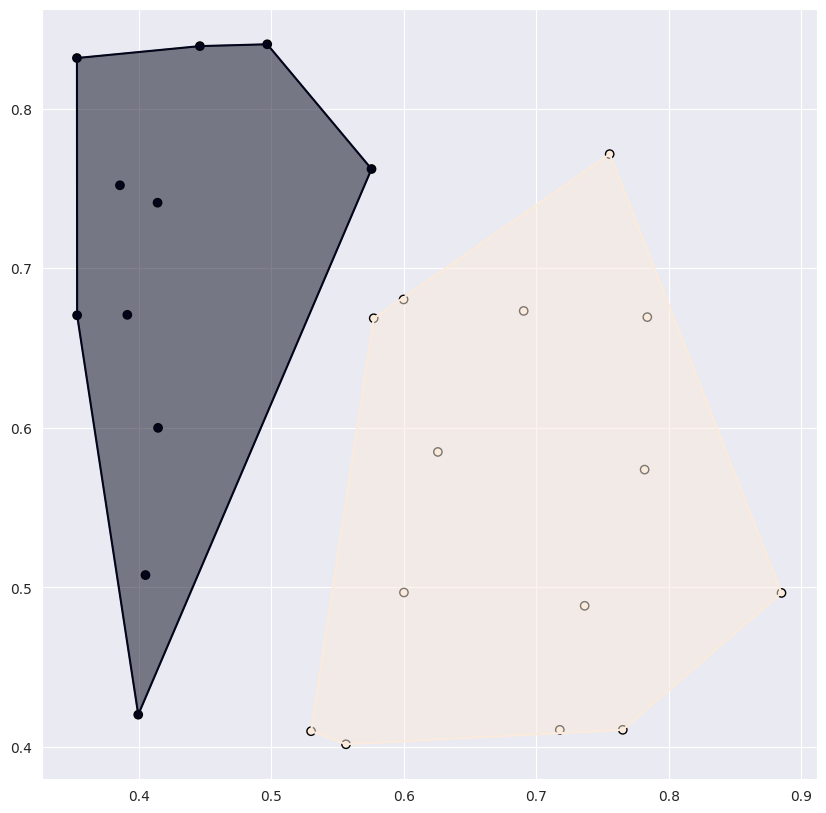

In [8]:
scanpath_visualization(result_tb[(result_tb['SUBJ_NAME'] == "s04") & (result_tb['TEXT'] == "chasse_oiseaux-a1")], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True, only_points=True)

You can also try other AOI definition methods.

## AOI extractor
The AOI extractor gets a list of the AOI methods and selects for AOI splitting with minimal entropy. It also supports Sklearn clustering methods. The extractor has an instance_column parameter. This is to separate particular instances, not records.

In [9]:
from sklearn.cluster import KMeans
from eyetracking.preprocessing.aoi_extraction import AOIExtractor

methods = [ThresholdBased(threshold=0.0, window_size=6), KMeans(n_clusters=3)]
extractor = AOIExtractor(methods=methods, x=x, y=y, pk=pk, instance_columns=['TEXT'], aoi_name='AOI', show_best=True)
extractor.fit(data)
result_extr = extractor.transform(data)

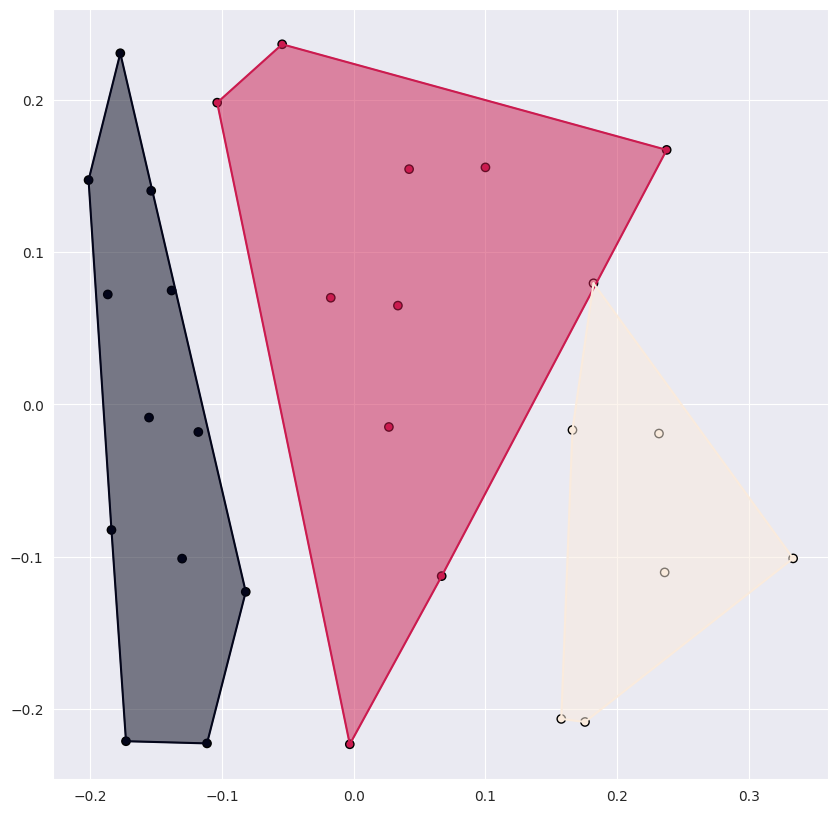

In [10]:
scanpath_visualization(result_extr[(result_extr['SUBJ_NAME'] == "s01") & (result_extr['TEXT'] == "chasse_oiseaux-a1")], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True, only_points=True)

We want to know which method was chosen more often. Let's check it.

In [11]:
df = pd.concat([result_extr.loc[result_extr['best_method'] == m.__class__.__name__].groupby("to_filter").size() for m in methods], axis=1)
df.rename(columns=dict(zip(df.columns, [el.__class__.__name__ for el in methods])), inplace=True)
check_count = df.count()
check_count

ThresholdBased    1393
KMeans             990
dtype: int64

<Axes: xlabel='None'>

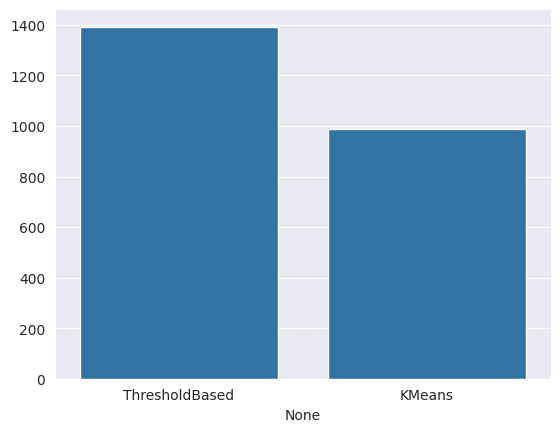

In [12]:
import seaborn as sns
sns.barplot(x=check_count.index, y=check_count.values)

## AOI Matcher 
Sometimes AOI methods shuffle AOI labels. The correct order of the AOI names and features is necessary for ML/DL. That is why the AOI matcher exists. Let's match the AOI.

In [13]:
from eyetracking.preprocessing.aoi_extraction import AOIMatcher
matcher = AOIMatcher(x=x, y=y, pk=pk, instance_columns=["TEXT"], aoi='AOI', n_aoi=3)
result_match = matcher.transform(result_extr)
result_match.head()

,SUBJ_NAME,TEXT,norm_pos_x,norm_pos_y,duration,to_filter,AOI,best_method
0,s01,aide_refugies-a1,-0.259043,-0.050774,119,s01_aide_refugies-a1,aoi_2,KMeans
1,s01,aide_refugies-a1,-0.172329,-0.043732,172,s01_aide_refugies-a1,aoi_2,KMeans
2,s01,aide_refugies-a1,-0.033891,-0.041002,103,s01_aide_refugies-a1,aoi_0,KMeans
3,s01,aide_refugies-a1,0.150820,-0.028931,236,s01_aide_refugies-a1,aoi_1,KMeans
4,s01,aide_refugies-a1,0.117732,-0.031087,173,s01_aide_refugies-a1,aoi_1,KMeans


The n_aoi parameter needs to limit the count of AOI for each record. It helps to avoid columns with NaN values.

## Pipeline
One of the most important features is the ability to use this in the Sklearn pipeline.

In [14]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('AOIExtractor', AOIExtractor(methods=methods, x=x, y=y, pk=pk, instance_columns=['TEXT'], aoi_name='AOI', show_best=True)), ("AOIMatcher", AOIMatcher(x=x, y=y, pk=pk, instance_columns=["TEXT"], aoi='AOI', n_aoi=3))])
pipeline.fit(data)
prep_data = pipeline.transform(data)

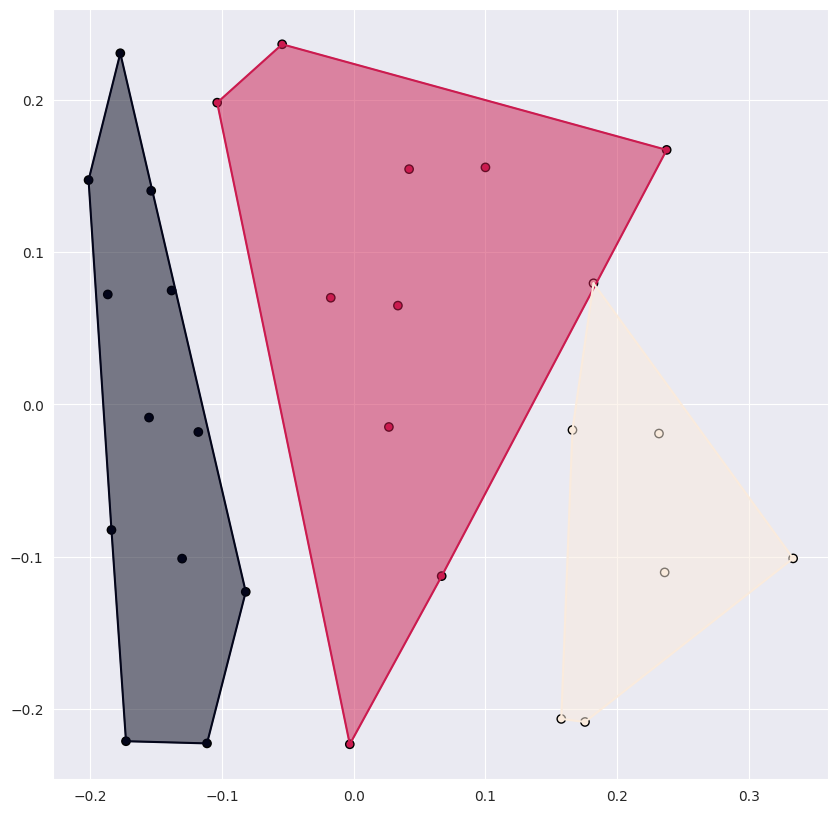

In [15]:
scanpath_visualization(prep_data[(prep_data['SUBJ_NAME'] == "s01") & (prep_data['TEXT'] == "chasse_oiseaux-a1")], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True, only_points=True)